Load up some ToO events and see "how well" they were observed

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import sqlite3

import rubin_sim.maf as maf

from rubin_scheduler.utils import hpid2_ra_dec, angular_separation

In [2]:
run_file = "too_elab_heavy_r128_d3_griz_v3.4_1yrs.db"
run_name = os.path.basename(run_file).replace(".db","")
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)



In [3]:
con = sqlite3.connect(run_file)
events = pd.read_sql('select * from events;', con)
con.close()

In [4]:
events.iloc[42]

index           42.000000
mjd_start    60902.632797
ra               4.257262
dec             -0.248325
expires      60905.632797
radius           0.069813
Name: 42, dtype: float64

In [5]:
# Start with checking one event
event_i = 42

In [9]:
nside = 128

radius = events.iloc[event_i]['radius'] #+ np.radians(5)

hpid_all = np.arange(hp.nside2npix(nside))

ra, dec = hpid2_ra_dec(nside, hpid_all)

dist = angular_separation(np.degrees(events.iloc[event_i]["ra"]), np.degrees(events.iloc[event_i]["dec"]), ra, dec) 

good_hp = np.where(dist <= np.degrees(radius))[0]


In [10]:
bundle_list = []

slicer = maf.HealpixSubsetSlicer(nside, good_hp)
sql = "observationStartMJD > %f and observationStartMJD < %f" % (events.iloc[event_i]['mjd_start'], events.iloc[event_i]['expires']+1)
metric = maf.CountMetric(col='fieldRA')

plot_dict={}

bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=run_name, plot_dict=plot_dict))


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


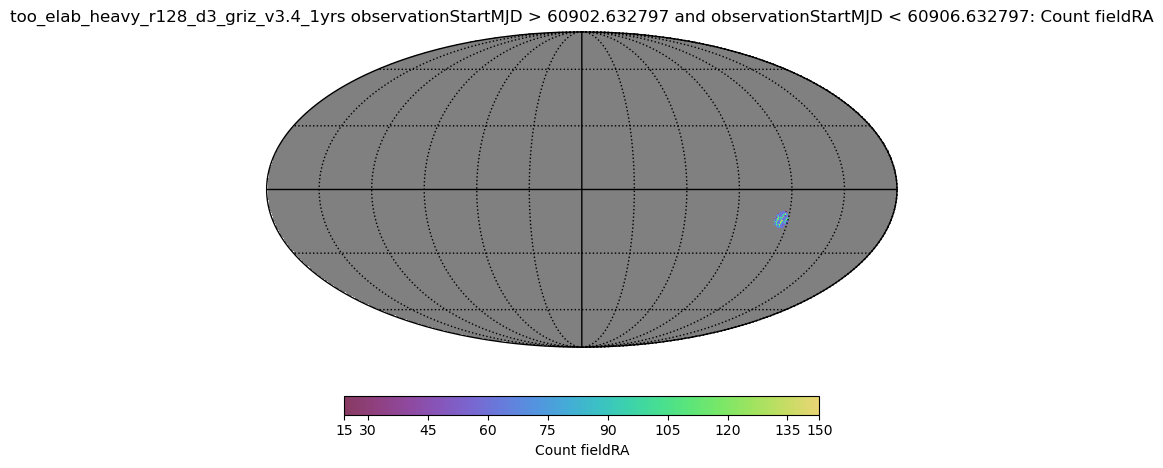

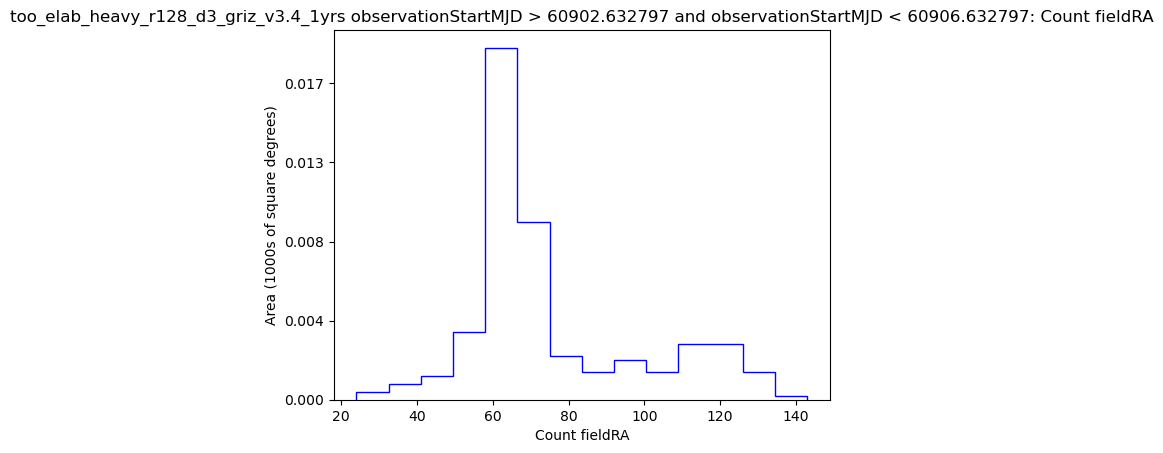

In [11]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, run_file, out_dir=out_dir, results_db=results_db)
bg.run_all()
bg.plot_all(closefigs=False)
